<a href="https://www.kaggle.com/code/samithsachidanandan/stock-price-prediction-in-python-with-pytorch?scriptVersionId=284014274" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#!pip install yfinance


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
device 

device(type='cuda')

In [5]:
ticker = 'AMD'
df = yf.download(ticker, '2020-01-01')

/tmp/ipykernel_20/4218411562.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [6]:
df 

Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2020-01-02,49.099998,49.250000,46.630001,46.860001,80331100
2020-01-03,48.599998,49.389999,47.540001,48.029999,73127400
2020-01-06,48.389999,48.860001,47.860001,48.020000,47934900
2020-01-07,48.250000,49.389999,48.040001,49.349998,58061400
2020-01-08,47.830002,48.299999,47.139999,47.849998,53767000
...,...,...,...,...,...
2025-11-28,217.529999,218.300003,214.020004,216.139999,18658000
2025-12-01,219.759995,220.979996,213.500000,213.880005,30768700


<Axes: xlabel='Date'>

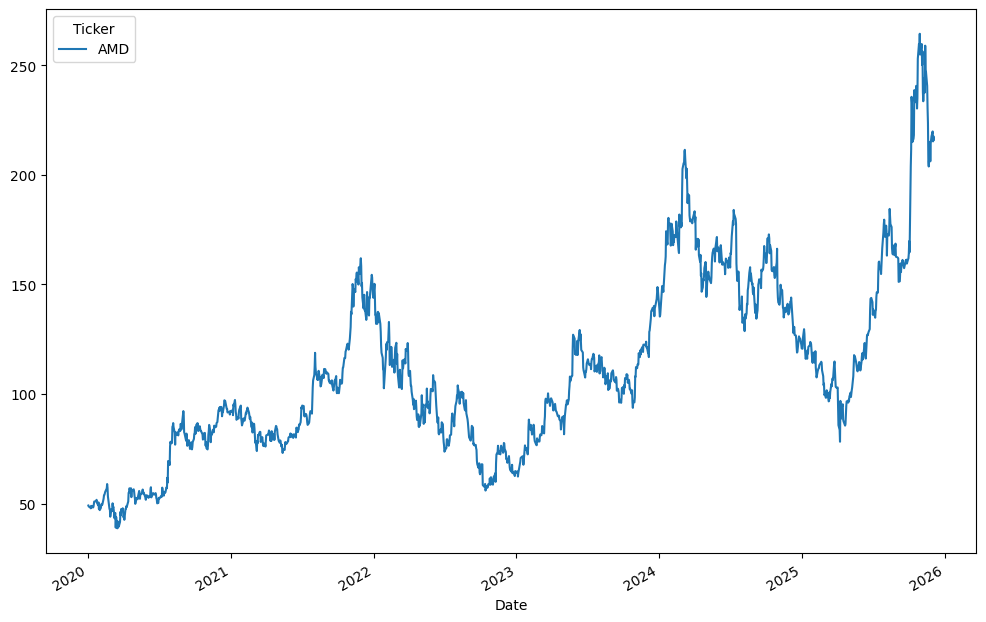

In [7]:
df.Close.plot(figsize = (12,8))

In [8]:
scaler = StandardScaler()

df['Close'] =  scaler.fit_transform(df['Close'])

In [9]:
df.Close

Ticker,AMD
Date,
2020-01-02,-1.483866
2020-01-03,-1.495947
2020-01-06,-1.501021
2020-01-07,-1.504404
2020-01-08,-1.514551
...,...
2025-11-28,2.585626
2025-12-01,2.639506
2025-12-02,2.530297


In [10]:
seq_length =30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close [i:i + seq_length])

data = np.array(data)



In [11]:
data

array([[[-1.48386648],
        [-1.49594714],
        [-1.501021  ],
        ...,
        [-1.37030821],
        [-1.36813369],
        [-1.35267045]],

       [[-1.49594714],
        [-1.501021  ],
        [-1.50440357],
        ...,
        [-1.36813369],
        [-1.35267045],
        [-1.33382455]],

       [[-1.501021  ],
        [-1.50440357],
        [-1.51455129],
        ...,
        [-1.35267045],
        [-1.33382455],
        [-1.2956497 ]],

       ...,

       [[ 3.14206169],
        [ 3.08093355],
        [ 2.89247511],
        ...,
        [ 2.50613568],
        [ 2.58562629],
        [ 2.63950595]],

       [[ 3.08093355],
        [ 2.89247511],
        [ 3.00748327],
        ...,
        [ 2.58562629],
        [ 2.63950595],
        [ 2.53029701]],

       [[ 2.89247511],
        [ 3.00748327],
        [ 3.44069574],
        ...,
        [ 2.63950595],
        [ 2.53029701],
        [ 2.58731776]]])

In [12]:

train_size = int(0.8 * len(data))

X_train = torch.from_numpy (data[: train_size, :-1, : ]).type(torch.Tensor).to(device)
y_train = torch.from_numpy (data[: train_size, -1, : ]).type(torch.Tensor).to(device)
X_test = torch.from_numpy (data[train_size :, :-1, : ]).type(torch.Tensor).to(device)
y_test = torch.from_numpy (data[train_size : , -1, : ]).type(torch.Tensor).to(device)

In [13]:
# class PredictionModel( nn.Module):

#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(PredictionModel, self).__init__()

#         self.num_layers = num_layers
#         self.hidden_dim = hidden_dim


#         self.lstm  = nn.LSTM(input_dim,  hidden_dim, num_layers, batch_first= True, dropout=0.2 )
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device= device )
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device= device )

#         out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
#         out = self.fc(out[:, -1, :])

#         return out 



    

In [14]:
class PredictionModel( nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, 
                     dropout=0.3, bidirectional=True, use_attention=True):
            super(PredictionModel, self).__init__()
            
            self.num_layers = num_layers
            self.hidden_dim = hidden_dim
            self.bidirectional = bidirectional
            self.use_attention = use_attention
            self.num_directions = 2 if bidirectional else 1
            
          
            self.lstm = nn.LSTM(
                input_dim, 
                hidden_dim, 
                num_layers, 
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=bidirectional
            )
            
    
            self.h0 = nn.Parameter(torch.zeros(num_layers * self.num_directions, 1, hidden_dim))
            self.c0 = nn.Parameter(torch.zeros(num_layers * self.num_directions, 1, hidden_dim))
            
            lstm_output_dim = hidden_dim * self.num_directions
            
           
            if use_attention:
                self.attention = nn.MultiheadAttention(
                    lstm_output_dim, 
                    num_heads=4, 
                    dropout=dropout,
                    batch_first=True
                )
                self.attention_dropout = nn.Dropout(dropout)
            

            self.ln1 = nn.LayerNorm(lstm_output_dim)
            self.ln2 = nn.LayerNorm(lstm_output_dim)
            

            self.fc1 = nn.Linear(lstm_output_dim, lstm_output_dim)
            self.fc2 = nn.Linear(lstm_output_dim, output_dim)
            
       
            self.dropout = nn.Dropout(dropout)
            
      
            self._init_weights()
        
    def _init_weights(self):

        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    nn.init.xavier_uniform_(param)
                elif 'fc' in name:
                    nn.init.kaiming_normal_(param, nonlinearity='relu')
            elif 'bias' in name:
                nn.init.constant_(param, 0)
    
    def forward(self, x, return_attention=False):
        batch_size = x.size(0)
        device = x.device
        
      
        h0 = self.h0.expand(-1, batch_size, -1).contiguous()
        c0 = self.c0.expand(-1, batch_size, -1).contiguous()
        
       
        lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
        

        if self.use_attention:
            attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)
            attn_out = self.attention_dropout(attn_out)
       
            lstm_out = lstm_out + attn_out
        else:
            attn_weights = None
        
   
        lstm_out = self.ln1(lstm_out)
        

        last_out = lstm_out[:, -1, :]
        
     
        residual = last_out
        out = self.fc1(last_out)
        out = F.relu(out)
        out = self.dropout(out)
        
    
        out = out + residual
        out = self.ln2(out)
        
      
        out = self.fc2(out)
        
        if return_attention and attn_weights is not None:
            return out, attn_weights
        return out


In [15]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
num_epochs = 200

for i in range (num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i  % 25 ==0:
        print(i, loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 tensor(2.7103, device='cuda:0', grad_fn=<MseLossBackward0>)
25 tensor(0.1276, device='cuda:0', grad_fn=<MseLossBackward0>)
50 tensor(0.0726, device='cuda:0', grad_fn=<MseLossBackward0>)
75 tensor(0.0370, device='cuda:0', grad_fn=<MseLossBackward0>)
100 tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)
125 tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)
150 tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)
175 tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)


In [18]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())


In [19]:
train_rmse = mean_squared_error(y_train[:,0], y_train_pred[:,0],squared=False)
test_rmse = mean_squared_error(y_test[:,0], y_test_pred[:,0],squared=False)

In [20]:
train_rmse

5.845285

In [21]:
test_rmse

9.830976

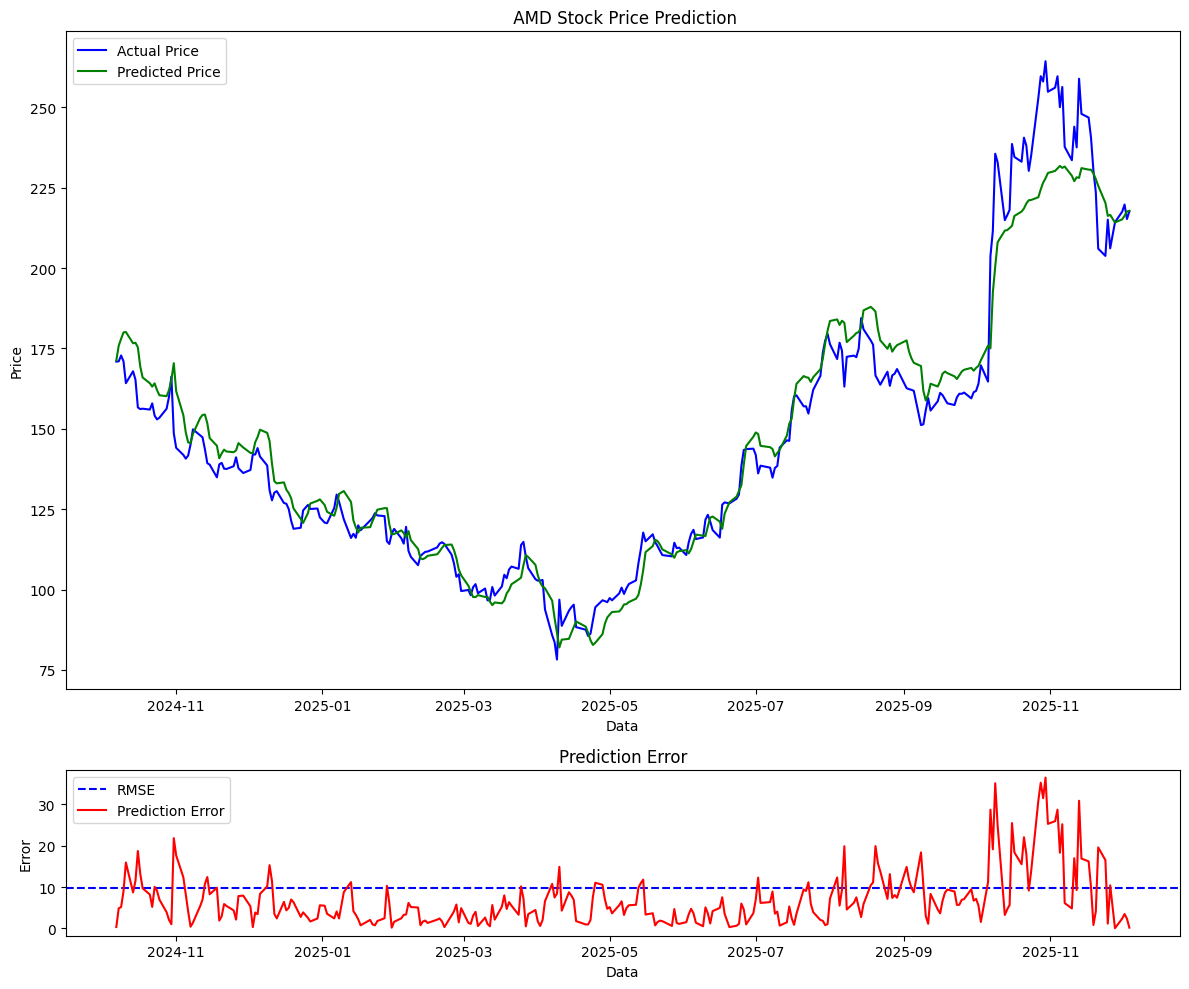

In [22]:
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4,1)
ax1 =fig.add_subplot(gs[:3,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label= 'Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label= 'Predicted Price')
ax1.legend()
plt.title(f" {ticker} Stock Price Prediction")
plt.xlabel('Data')
plt.ylabel('Price')



ax2 = fig.add_subplot(gs [3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label = 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Data')
plt.ylabel('Error')
plt.tight_layout()
plt.show()



